In [1]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from collections import namedtuple
from scipy.signal import find_peaks


Signal = namedtuple("Signal", ["y", "fs", "file"])


# create a signal from a file
def signal_from_file(filename):
    # read the audio file
    fs, y = wav.read(filename)

    # normalize the signal
    # signal values are stored as 16-bit integers
    y = y / 2**15

    return Signal(y, fs, os.path.basename(filename))


def plot_signal(y, fs, title, peaks=None, vline=None):
    t = np.arange(len(y)) / fs

    plt.plot(t, y)

    if peaks is not None:
        plt.plot(peaks / fs, y[peaks], "x")

    if vline is not None:
        for x in vline:
            plt.axvline(x, color="r")

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.show()


# decompose a signal into non overlapping frames
def non_overlapping_frames(signal, frame_duration):
    frame_len = round(frame_duration * signal.fs)
    total_frames = len(signal.y) // frame_len

    frames = signal.y[: total_frames * frame_len]
    frames = frames.reshape(frame_len, total_frames, order="F")

    return frames

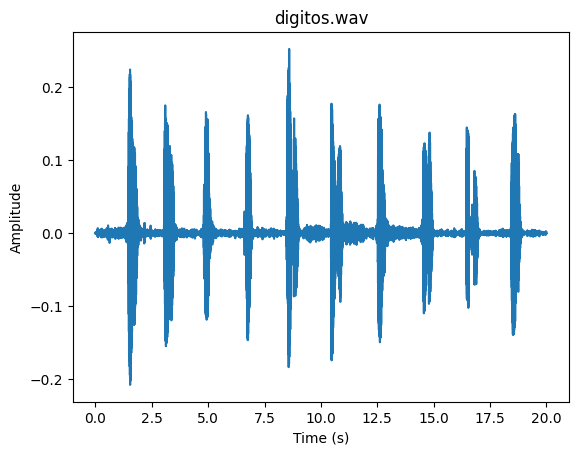

[ 1.64  3.2   4.88  6.78  8.74 10.7  12.68 14.72 16.72 18.62]


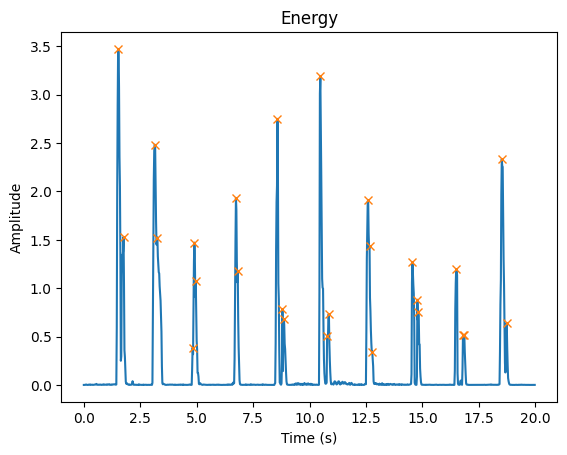

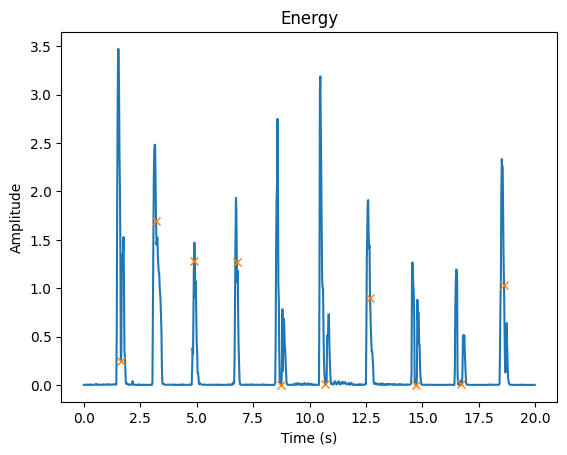

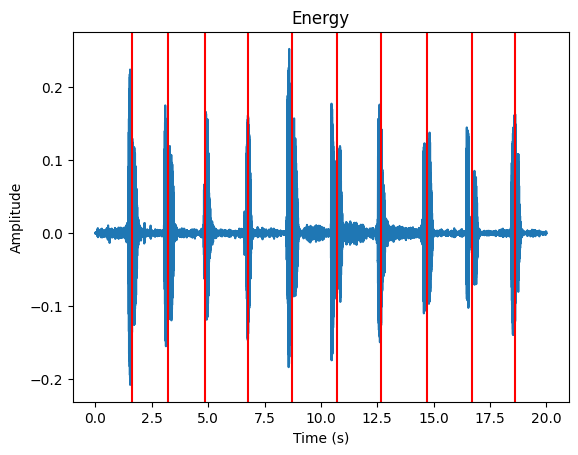

In [2]:
signal = signal_from_file("digitos.wav")
plot_signal(signal.y, signal.fs, signal.file)

frame_duration = 0.02
frames = non_overlapping_frames(signal, frame_duration)
frame_len, total_frames = frames.shape
frames_fs = 1 / frame_duration

energy_frames = np.sum(frames**2, axis=0)

peaks, _ = find_peaks(energy_frames, height=0.3)

last_peak = peaks[0]
current_peaks = []
mid_values = []
dispersion = []
for peak in peaks:
    if peak - last_peak < 0.5 * frames_fs:
        current_peaks.append(peak)
    else:
        mid_values.append(np.mean(current_peaks))
        dispersion.append(np.std(current_peaks))
        current_peaks = [peak]

    last_peak = peak

# add the last peak
mid_values.append(np.mean(current_peaks))
dispersion.append(np.std(current_peaks))

mid_values = np.array(mid_values).astype(int)
signal_mid_values = mid_values / frames_fs
signal_dispersion = np.array(dispersion) / frames_fs

plot_signal(energy_frames, frames_fs, "Energy", peaks=peaks)
plot_signal(energy_frames, frames_fs, "Energy", peaks=mid_values)
plot_signal(signal.y, signal.fs, "Energy", vline=signal_mid_values)

for value, disp in zip(signal_mid_values, signal_dispersion):
    speech_start = round((value - disp) * signal.fs)
    speech_end = round((value + disp) * signal.fs)